In [ ]:
#code: utf-8
from google.colab import drive
import sys
import os
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as albu

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score

#from tqdm import tqdm
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as pat
import seaborn as sns

In [ ]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
SEED = 2021
set_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#defining hyper-parameters

In [ ]:
STATE_SIZE = 8*8
#model parameter
MODEL_NAME = "conv1"
KSIZE = 3
INPUT_SIZE = 3
#train parameter
BATCH_SIZE = 128
n_FOLD = 5
EPOCH = 10 #30 #max = 10 - 30 ? for 3.5 hours
LERNING_RATE = 0.0001
EARLY_STOP = 10
#save name
TRAIN = False
CONTINUE = False #load param or not
No = 0#30 #
PARAM_NAME = f"SLpn_{MODEL_NAME}_{No}"
BEST_PARAM_NAME = f"SLpn_{MODEL_NAME}_{No}_best"
LOSS_ACC_NAME = f"SLpn_loss_acc_{MODEL_NAME}_{No}"
#for debug to reduce data
DEBUG = False
if CONTINUE:
  if DEBUG:
    #DEBUG = False
    print(f"check your doing! CONTINUE is True but DEBUG is True.")

model name:

  conv1:
    0: for rollout in MCTS 10 EPOCH lr=0.001

  conv2_bn:
    101: acc 0.5? all data v_past 15: all data nondup

  conv4_bn:
    0: all data v_past 30:30epoch nondup

  conv4_bn_mini:
    4: all data v_past 0.57, 20: all data nondup, 23:no-transform 30:30epochs 40:24epochs non dup is_right_action


In [ ]:
drive.mount('/content/gdrive')
ROOT_PATH = '/content/gdrive/My Drive/Colab Notebooks'
if ROOT_PATH not in sys.path:
  sys.path.append(ROOT_PATH)
PARAM_PATH = os.path.join(ROOT_PATH, "Othello_AI", "SLpn_params", f"{PARAM_NAME}.pth")
BEST_PARAM_PATH = os.path.join(ROOT_PATH, "Othello_AI", "SLpn_params", f"{BEST_PARAM_NAME}.pth")
LOSS_ACC_PATH = os.path.join(ROOT_PATH, "Othello_AI", "SLpn_params", f"{LOSS_ACC_NAME}.txt")

Mounted at /content/gdrive


#Loading Data

 Othello_Kihu.txt: Raw data

    
Othello_Kihu.csv: Raw Data to csv


Othello_Kihu_nondup.csv: Droped duplicated data:


Othello_Kihu_nd_rightaction.csv: Droped wrong action data in non duplicated data

In [ ]:
#Load for Othello_Kihu.csv
state_name = [f'state{x}' for x in range(64)]
print("Loading data for csv.file...") #16s
#train_df = pd.read_csv(os.path.join(ROOT_PATH, "Othello_data", "Othello_Kihu_nondup.csv"), dtype = "int8")
train_df = pd.read_csv(os.path.join(ROOT_PATH, "Othello_data", "Othello_Kihu_nd_rightaction.csv"), dtype = "int8")
print(train_df.columns)
#train_df.info()
print(len(train_df))
#print(train_df.describe)
#print(train_df[state_name].head())

Loading data for csv.file...
Index(['state0', 'state1', 'state2', 'state3', 'state4', 'state5', 'state6',
       'state7', 'state8', 'state9', 'state10', 'state11', 'state12',
       'state13', 'state14', 'state15', 'state16', 'state17', 'state18',
       'state19', 'state20', 'state21', 'state22', 'state23', 'state24',
       'state25', 'state26', 'state27', 'state28', 'state29', 'state30',
       'state31', 'state32', 'state33', 'state34', 'state35', 'state36',
       'state37', 'state38', 'state39', 'state40', 'state41', 'state42',
       'state43', 'state44', 'state45', 'state46', 'state47', 'state48',
       'state49', 'state50', 'state51', 'state52', 'state53', 'state54',
       'state55', 'state56', 'state57', 'state58', 'state59', 'state60',
       'state61', 'state62', 'state63', 'action_x', 'action_y', 'action',
       'player_w', 'player_b', 'count_void', 'num_place', 'is_right_action'],
      dtype='object')
3337998


#viewing data

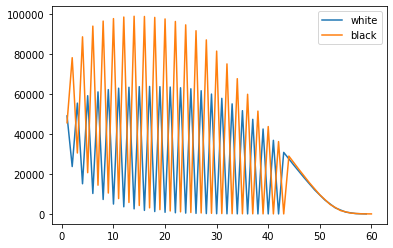

all: 3337998 white: 1374712 black: 1963286


In [ ]:
#print(train_df.head())
white_df = train_df[train_df["player_w"] == 1]
black_df = train_df[train_df["player_b"] == 1]
#print(white_df.describe())
#print(black_df.describe())
fig, ax = plt.subplots(1,1)
wd = white_df["count_void"].value_counts().sort_index()
bd = black_df["count_void"].value_counts().sort_index()
ax.plot(wd, label = "white")
ax.plot(bd, label = "black")
ax.legend(loc = "upper right")
plt.show()
print(f"all: {len(train_df)} white: {len(white_df)} black: {len(black_df)}")

In [ ]:
print(train_df.is_right_action.value_counts())

1    3337998
Name: is_right_action, dtype: int64


#making data splitter and viewing data

In [ ]:
KF = KFold(n_splits=n_FOLD, shuffle=True)
GKF = GroupKFold(n_splits=n_FOLD)
STK = StratifiedKFold(n_splits=n_FOLD)
#groups = train_df["count_void"].values()

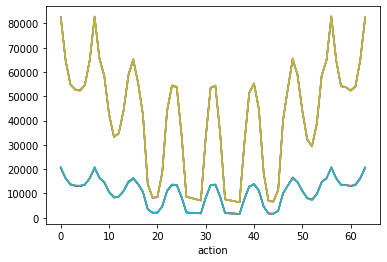

In [ ]:
#splitter = GKF.split()
#splitter = STK.split()
splitter = KF.split(train_df.state0, train_df.action)
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("action")
for train, test in splitter:
  pt = train_df.loc[train, "action"].value_counts().sort_index()
  tpt = train_df.loc[test, "action"].value_counts().sort_index()
  pt.plot()
  tpt.plot()
plt.show()

#making transform

In [ ]:
#transform for action
def rotate90(x, y, k):
  for _ in range(k):
    x, y = y, -1*x + 7
  return x, y

def flip(x, y):
  x, y = x, -1*y + 7
  return x, y

In [ ]:
#making transform
def transform(state, action, mode = "None"):
  x, y = action%8, action//8
  if mode == "train":
    k = random.randint(0, 3)
    p = k % 2
    if p > 0:
      state = np.flip(state, axis=1).copy()
      x, y = flip(x, y)
    state = np.rot90(state, k, axes=(1, 2)).copy()
    x, y = rotate90(x, y, k)

  elif mode == "valid":
    pass

  elif mode == "debug":
    k = 3 #0-3 existable pattern
    p = k % 2
    if p > 0:
      state = np.flip(state, axis=1).copy()
      x, y = flip(x, y)
    state = np.rot90(state, k, axes=(1, 2)).copy()
    x, y = rotate90(x, y, k)

  else:
    pass
    
  action = x + y*8
  return state, action

In [ ]:
transtest = train_df.sample(2)
image = transtest.loc[:, state_name].values
image = image.reshape(-1, 8, 8)
label_a = transtest.loc[:, "action"].values
print(image, label_a)
image, label_a = transform(image, label_a, "debug")
print(image, label_a)

[[[1 1 1 1 1 1 1 1]
  [0 1 1 2 1 2 0 1]
  [2 1 1 1 2 2 1 2]
  [2 2 1 2 1 1 2 2]
  [2 2 2 2 1 2 2 2]
  [2 2 1 1 2 2 2 2]
  [2 0 1 1 1 2 0 0]
  [0 1 0 2 2 2 2 0]]

 [[0 1 1 1 1 1 0 0]
  [0 0 2 1 2 1 0 0]
  [0 1 2 2 1 2 1 1]
  [1 1 1 1 2 1 1 1]
  [1 1 1 1 2 2 1 2]
  [1 1 2 1 1 1 0 2]
  [1 0 2 2 1 1 0 2]
  [0 0 1 1 1 1 1 0]]] [14 46]
[[[1 0 2 2 2 2 2 0]
  [1 1 1 2 2 2 0 1]
  [1 1 1 1 2 1 1 0]
  [1 2 1 2 2 1 1 2]
  [1 1 2 1 1 2 1 2]
  [1 2 2 1 2 2 2 2]
  [1 0 1 2 2 2 0 2]
  [1 1 2 2 2 2 0 0]]

 [[0 0 0 1 1 1 1 0]
  [1 0 1 1 1 1 0 0]
  [1 2 2 1 1 2 2 1]
  [1 1 2 1 1 1 2 1]
  [1 2 1 2 2 1 1 1]
  [1 1 2 1 2 1 1 1]
  [0 0 1 1 1 0 0 1]
  [0 0 1 1 2 2 2 0]]] [49 53]


#making dataset

In [ ]:
#making class dataset
color = [1, 2] #[W, B]
#player = black : default, = white : inverse
class TrainDatasets(Dataset):
  def __init__(self, state_df, action, player_df, mode = None):
    self.state_np = state_df.values
    self.action = action.values
    self.player_w = player_df["player_w"].values
    self.player_w = np.where(self.player_w == 1, 2, 1) 
    self.player_b = player_df["player_b"].values
    self.player_b = np.where(self.player_b == 1, 2, 1)
    self.mode = mode

  def __len__(self):
    return self.player_w.shape[0]
  
  def __getitem__(self, idx):
    state = self.state_np[idx].reshape((-1, 8, 8)).astype("float32")
    white_st = np.where(state == self.player_w[idx], 1, 0)
    black_st = np.where(state == self.player_b[idx], 1, 0)
    bw_st = np.where(state > 0, 1, 0)
    state = np.stack([bw_st, white_st, black_st], axis = 1).reshape(3, 8, 8) #check INPUT_SIZE
    action = self.action[idx]
    if self.mode:
      state, action = transform(state, action, self.mode)
    state = torch.tensor(state).float()
    action = torch.tensor(action).long()
    return state, action

#making model

In [ ]:
class Conv4_bn(nn.Module):
  def __init__(self):
    super(Conv4_bn, self).__init__()
    self.relu = nn.ReLU()

    self.bn1 = nn.BatchNorm2d(64)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d(128)

    self.conv1 = nn.Conv2d(3, 64, KSIZE, padding=1)
    self.conv2 = nn.Conv2d(64, 64, KSIZE, padding=1)
    self.conv3 = nn.Conv2d(64, 128, KSIZE, padding=1)
    self.conv4 = nn.Conv2d(128, 128, KSIZE, padding=1)

    self.flatten = nn.Flatten()
    
    self.fc1 = nn.Linear(128*8*8, 128)
    self.fc2 = nn.Linear(128, 64)

  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.relu(self.bn3(self.conv3(x)))
    x = self.relu(self.bn4(self.conv4(x)))
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [ ]:
class Conv4_bn_mini(nn.Module):
  def __init__(self):
    super(Conv4_bn_mini, self).__init__()
    self.relu = nn.ReLU()

    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(32)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(64)

    self.conv1 = nn.Conv2d(3, 32, KSIZE, padding=1)
    self.conv2 = nn.Conv2d(32, 32, KSIZE, padding=1)
    self.conv3 = nn.Conv2d(32, 64, KSIZE, padding=1)
    self.conv4 = nn.Conv2d(64, 64, KSIZE, padding=1)

    self.flatten = nn.Flatten()
    
    self.fc1 = nn.Linear(64*8*8, 64)

  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.relu(self.bn3(self.conv3(x)))
    x = self.relu(self.bn4(self.conv4(x)))
    x = self.flatten(x)
    x = self.fc1(x)
    return x

In [ ]:
class Conv2_bn(nn.Module):
  def __init__(self):
    super(Conv2_bn, self).__init__()
    self.relu = nn.ReLU()

    self.bn1 = nn.BatchNorm2d(64)
    self.bn2 = nn.BatchNorm2d(128)

    self.conv1 = nn.Conv2d(3, 64, KSIZE, padding=1)
    self.conv2 = nn.Conv2d(64, 128, KSIZE, padding=1)

    self.flatten = nn.Flatten()
    
    self.fc1 = nn.Linear(128*8*8, 128)
    self.fc2 = nn.Linear(128, 64)

  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [ ]:
class Conv1(nn.Module):
  def __init__(self):
    super(Conv1, self).__init__()
    self.relu = nn.ReLU()

    self.bn1 = nn.BatchNorm2d(1)

    self.conv1 = nn.Conv2d(3, 1, 3, padding=1)

    self.flatten = nn.Flatten()
    
    self.fc1 = nn.Linear(1*64, 64)

  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.flatten(x)
    x = self.fc1(x)
    return x

#making trainer

In [ ]:
def trainer(train_loader, valid_loader, model, criterion, optimizer, device, fold):
    
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    model.train()
    #pbar = tqdm(train_loader, desc=f'[{its} its] train: ')
    for i, (states, actions) in enumerate(train_loader):
      #pbar.set_description()
      #pbar.set_postfix_str(f' loss:{train_loss:.4f} acc:{train_acc:.4f}')
      states = states.to(device)
      actions = actions.to(device)
      #players = players.to(device)
      
      optimizer.zero_grad()
      outputs = model(states)

      loss = criterion(outputs, actions)
      loss.backward()
      optimizer.step()
      
      train_loss += loss.item() / len(train_loader)
      
      acc = accuracy_score(actions.cpu().detach().numpy(),
                           np.argmax(outputs.cpu().detach().numpy(), axis=1)) 
      train_acc += acc / len(train_loader)
      #if i % (len(train_loader)//5) == 0:
        #print(f"  train [{i+1}/{len(train_loader)}] loss: {loss:.4f} acc: {acc:.4f}")
        
    model.eval()
    with torch.no_grad():
      #pbar = tqdm(valid_loader, desc=f'[{its} its] valid: ')
      for i, (states, actions) in enumerate(valid_loader):
        #pbar.set_postfix_str(f' loss:{val_loss:.4f} acc:{val_acc:.4f}')
        states = states.to(device)
        actions = actions.to(device)
        #players = players.to(device)
        
        outputs = model(states)
        loss = criterion(outputs, actions)
        
        val_loss += loss.item() / len(valid_loader)
        
        acc = accuracy_score(actions.cpu().detach().numpy(),
                             np.argmax(outputs.cpu().detach().numpy(), axis=1))
        val_acc += acc / len(valid_loader)
        #if i % (len(valid_loader)//3) == 0:
          #print(f"  valid [{i+1}/{len(valid_loader)}] loss: {loss:.4f} acc: {acc:.4f}")
            
    return train_loss, train_acc, val_loss, val_acc

#train iteration

In [ ]:
def main(state_df, action_df, model, criterion, optimizer, device, Epoch): 

  for fold, (train_index, valid_index) in enumerate(KF.split(state_df, action_df)):
    state_train = state_df.iloc[train_index]
    action_train = action_df.iloc[train_index]
    player_train = player_df.iloc[train_index]
    state_valid = state_df.iloc[valid_index]
    action_valid = action_df.iloc[valid_index]
    player_valid = player_df.iloc[valid_index]
    
    train_dataset = TrainDatasets(state_train, action_train, player_train, 'train')
    valid_dataset = TrainDatasets(state_valid, action_valid, player_valid, 'valid')
    
    train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
    valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = False)

    train_loss_data, train_acc_data = [], []
    val_loss_data, val_acc_data = [], [] 
    best_val_loss, best_val_acc = 100, 0.0

    if CONTINUE:
      with open(LOSS_ACC_PATH, "r") as f:
        loss_acc_data = list(map(float, f.read().split()))
      last_epoch = int(loss_acc_data[-1])+1
      len_data = int(loss_acc_data[-2])
      train_loss_data = loss_acc_data[:len_data]
      train_acc_data = loss_acc_data[len_data : 2*len_data]
      val_loss_data = loss_acc_data[2*len_data : 3*len_data]
      val_acc_data = loss_acc_data[3*len_data : 4*len_data]
      best_val_loss = min(val_loss_data)
      best_val_acc = max(val_acc_data)
      print(f"loaded params for {MODEL_NAME} No.{No} mode_{fold}")
      print(f"last epoch : {last_epoch} best_valid_loss : {best_val_loss:.4f} best_valid_acc : {best_val_acc:.4f}")
    else:
      print(f"{MODEL_NAME} No.{No} model_{fold}")

    if fold == 0:
      for epoch in range(Epoch):
        #print(f'Epoch[{epoch+1}/{Epoch}]')
        train_loss, train_acc, valid_loss, valid_acc = trainer(train_loader, valid_loader, model, criterion, optimizer, device, fold)
        print(f'Epoch [{epoch+1}/{Epoch}] <mean> train loss:{train_loss:.4f} acc:{train_acc:.4f} valid loss:{valid_loss:.4f} acc:{valid_acc:.4f}')

        train_loss_data.append(train_loss)
        train_acc_data.append(train_acc)
        val_loss_data.append(valid_loss)
        val_acc_data.append(valid_acc)
        
        if best_val_loss > valid_loss:
          best_val_loss = valid_loss
          
          #torch.save(model.state_dict(), BEST_PARAM_PATH)
          #print(f'saved best params. val_loss:{best_val_loss:.4f}')
          #tqdm.write(f'saved best params. val_loss:{best_val_loss:.4f}')

        if best_val_acc < valid_acc:
          stop = 0
          best_val_acc = valid_acc
          torch.save(model.state_dict(), BEST_PARAM_PATH)
          print(f'saved best params. val_acc: {best_val_acc:.4f}')
        else:
          stop += 1
      
        torch.save(model.state_dict(), PARAM_PATH)
        #print(f'saved params.')

        with open(LOSS_ACC_PATH, "w") as f:
          loss_acc_data = []
          for data in (train_loss_data, train_acc_data, val_loss_data, val_acc_data):
            loss_acc_data[len(loss_acc_data):] = data
          loss_acc_data[len(loss_acc_data):] = [len(train_loss_data), epoch]
          f.write(" ".join(map(str, loss_acc_data)))
    
        if stop > EARLY_STOP:
          print(f"early stopping!: not impoving acc for {EARLY_STOP} epochs.")
          print(f"Epoch[{epoch+1}/{Epoch}] best_valid_loss: {best_val_loss:.4f} best_valid_acc: {best_val_acc:.4f}")
          break

      return train_loss_data, train_acc_data, val_loss_data, val_acc_data, epoch

In [ ]:
def make_model(model_name):
  if model_name == "conv4_bn":
    return Conv4_bn().to(device)
  elif model_name == "conv4_bn_mini":
    return Conv4_bn_mini().to(device)
  elif model_name == "conv2_bn":
    return Conv2_bn().to(device)
  elif model_name == "conv1":
    return Conv1().to(device)
  else:
    print(f"{model_name} not exist.")
    return 0

In [ ]:
model_name = MODEL_NAME
if model_name == "conv4_bn":
  model = Conv4_bn().to(device)
elif model_name == "conv4_bn_mini":
  model = Conv4_bn_mini().to(device)
elif model_name == "conv2_bn":
  model = Conv2_bn().to(device)
elif model_name == "conv1":
  model = Conv1().to(device)
else:
  print(f"{model_name} not exist.")
  model = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), LERNING_RATE)

if CONTINUE or not TRAIN:
  model.load_state_dict(torch.load(PARAM_PATH, map_location = device))

In [ ]:
if DEBUG:
  train_df = train_df.sample(10000)
state_df = train_df[state_name]
action_df = train_df["action"]
player_df = train_df[["player_w", "player_b"]]

#Train Epoch

In [ ]:
##
if TRAIN:
  train_loss_dt, train_acc_dt, val_loss_dt, val_acc_dt, last_epoch = main(state_df, action_df, model, criterion, optimizer, device, EPOCH)

conv1 No.0 model_0
Epoch [1/10] <mean> train loss:2.3282 acc:0.2545 valid loss:2.1428 acc:0.2903
saved best params. val_acc: 0.2903
Epoch [2/10] <mean> train loss:2.1181 acc:0.2959 valid loss:2.0963 acc:0.2953
saved best params. val_acc: 0.2953
Epoch [3/10] <mean> train loss:2.0930 acc:0.2967 valid loss:2.0784 acc:0.2972
saved best params. val_acc: 0.2972
Epoch [4/10] <mean> train loss:2.0810 acc:0.2960 valid loss:2.0664 acc:0.2988
saved best params. val_acc: 0.2988
Epoch [5/10] <mean> train loss:2.0750 acc:0.2954 valid loss:2.0629 acc:0.2974
Epoch [6/10] <mean> train loss:2.0715 acc:0.2953 valid loss:2.0508 acc:0.2980
Epoch [7/10] <mean> train loss:2.0689 acc:0.2954 valid loss:2.0610 acc:0.2938
Epoch [8/10] <mean> train loss:2.0669 acc:0.2952 valid loss:2.0499 acc:0.2975
Epoch [9/10] <mean> train loss:2.0656 acc:0.2953 valid loss:2.0482 acc:0.2976
Epoch [10/10] <mean> train loss:2.0642 acc:0.2956 valid loss:2.0457 acc:0.2986


#loss and acc of train and valid graph par iterators

loaded params for conv1 No.0 mode_0
last epoch : 9 best_valid_loss : 2.0457 best_valid_acc : 0.2988


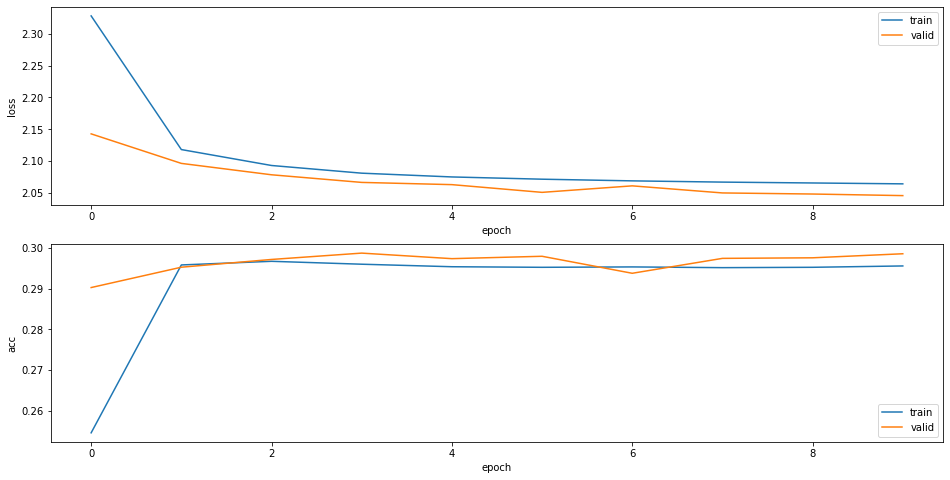

In [ ]:
if not TRAIN:
  with open(LOSS_ACC_PATH, "r") as f:
    loss_acc_data = list(map(float, f.read().split()))
    last_epoch = int(loss_acc_data[-1]) + 1
    len_data = int(loss_acc_data[-2])
    train_loss_dt = loss_acc_data[:len_data]
    train_acc_dt = loss_acc_data[len_data : 2*len_data]
    val_loss_dt = loss_acc_data[2*len_data : 3*len_data]
    val_acc_dt = loss_acc_data[3*len_data : 4*len_data]
best_val_loss = min(val_loss_dt)
best_val_acc = max(val_acc_dt)
print(f"loaded params for {MODEL_NAME} No.{No} mode_{0}")
print(f"last epoch : {last_epoch} best_valid_loss : {best_val_loss:.4f} best_valid_acc : {best_val_acc:.4f}")

train_loss_hist = pd.DataFrame(train_loss_dt)
train_acc_hist = pd.DataFrame(train_acc_dt)
val_loss_hist = pd.DataFrame(val_loss_dt)
val_acc_hist = pd.DataFrame(val_acc_dt)
fig, axes = plt.subplots(2, 1, figsize=(16, 8))
axes[0].plot(train_loss_hist, label = "train")
axes[0].plot(val_loss_hist, label = "valid")
axes[0].legend(loc = "best")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[1].plot(train_acc_hist, label = "train")
axes[1].plot(val_acc_hist, label = "valid")
axes[1].legend(loc = "best")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("acc")
plt.show()

#viewing prediction

prediction: tensor([24, 32, 12, 31, 46, 52, 30, 13,  1, 18], device='cuda:0')
answer    : tensor([[23, 32, 40, 31, 33,  6, 47, 55, 57,  2]])


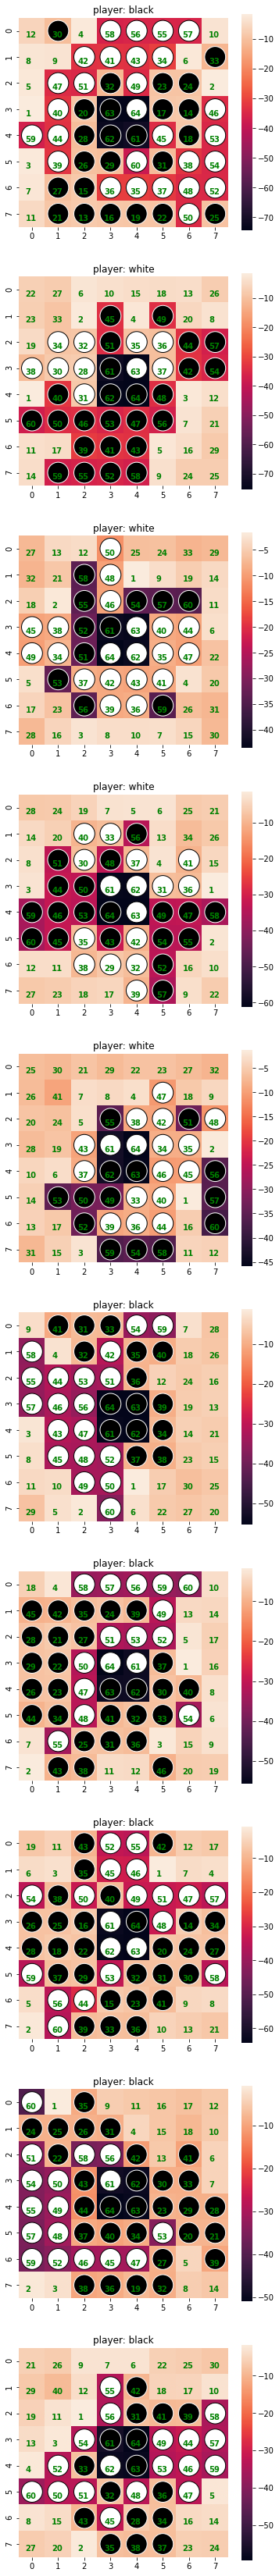

In [ ]:
#model.load_state_dict(torch.load(PARAM_PATH, map_location = device))
n_show = 10
pred_df = train_df.sample(n_show)
state = pred_df.loc[:, state_name]
action = pred_df.loc[:, ["action"]]
player = pred_df.loc[:, ["player_w", "player_b"]]
pred_dataset = TrainDatasets(state, action, player)
pred_loader = DataLoader(pred_dataset, n_show)

plot_state = state.values.reshape((-1, 8, 8))

for st, ac in pred_loader:
  model.eval()
  with torch.no_grad():
    st = st.to(device)
    pred = model(st)
    print("prediction:", torch.argmax(pred, dim=1))
    print("answer    :", ac.reshape(1, -1))
    pred = nn.LogSoftmax(dim = 1)(pred)
    pred = pred.clone().detach().to('cpu').numpy()
pred = pred.reshape(-1, 8, 8)
player =player.values

fig, axes= plt.subplots(n_show, 1, figsize=(6, 6*n_show))
for i in range(n_show):
  sns.heatmap(pred[i], square = True, ax = axes[i])

  for y in range(8):
    for x in range(8):
      st = plot_state[i][y][x]
      if st > 0:
        if st == 1:
          fc, ec = 'w', 'k' #face=white, edge=black
        elif st == 2:
          fc, ec = 'k', 'w'
        c = pat.Circle(xy = (x+0.5, y+0.5), radius=0.4, fc=fc, ec=ec, fill = True)
        axes[i].add_artist(c)

  pred_num = np.argsort(-pred[i].reshape(64))
  for y in range(8):
    for x in range(8):
      px = pred_num[x + y*8] % 8
      py = pred_num[x + y*8] // 8
      axes[i].text(px+0.25, py+0.75, f"{x + y*8 + 1}", size=10, color='green', fontweight='bold')
  if player[i, 0] == 1:
    title = "player: white"
  else:
    title = "player: black"
  axes[i].set_title(title)
plt.show()